# CLASIFICACION USING MULTILAYER PERCEPTRON


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import IPython
import IPython.display

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

## Metrics
acc_metric = tf.keras.metrics.Accuracy()
binary_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [4]:
def compute_metrics_classification(y, y_pred_label, average='binary'):
    acc = accuracy_score(y, y_pred_label)
            
    presicion = precision_score(y, y_pred_label, average=average)
    recall = recall_score(y, y_pred_label, average=average)
    balanced = balanced_accuracy_score(y, y_pred_label)        
    return {'acc':acc, 'presicion':presicion, 'recall':recall, 'balanced':balanced}    

def compute_curves(y, y_pred_prob, pos_label=1, plot=False):
    precision, recall_tpr_0, thresholds = precision_recall_curve(y, y_pred_prob[:, pos_label], pos_label=pos_label)
    print('precision-recall curve for the class ', pos_label)
    
    fpr, recall_tpr_1, thresholds = roc_curve(y, y_pred_prob[:,pos_label], pos_label=pos_label)
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
        ax[0].plot(recall_tpr_0, precision)
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Presicion')
        ax[0].set_title('Presicion - Recall curve')
        ax[1].plot(fpr, recall_tpr_1)
        ax[1].set_xlabel('1-TNR')
        ax[1].set_ylabel('Recall')
        ax[1].set_title('ROC curve')
    
    return {'pr_curve': auc(recall_tpr_0, precision), 'roc_curve':auc(fpr, recall_tpr_1)}
    
def predict_classes(y_prob):
    return np.argmax(y_prob, axis=1), np.max(y_prob, axis=1)    

def get_predictions(ds):
    list_y = []
    list_y_pred = []
    for x_batch, y_batch in iter(ds):        
      list_y.append(y_batch.numpy())
      list_y_pred.append(model.predict_on_batch(x_batch))

    #prediction return logits (see the architecture)
    return np.vstack(list_y), tf.nn.softmax(np.vstack(list_y_pred), axis=1)     

def compute_metrics_sklearn(y, y_pred_label, average='binary'):
    acc = accuracy_score(y, y_pred_label)
            
    presicion = precision_score(y, y_pred_label, average=average)
    recall = recall_score(y, y_pred_label, average=average)
    balanced = balanced_accuracy_score(y, y_pred_label)        
    return {'acc':acc, 'presicion':presicion, 'recall':recall, 'balanced':balanced}    

def ploting_probilities_surfaces(X, y, model, show_data=True,figsize=(10, 8)):
# def ploting_probilities_surfaces(X, y, predict_class, predict_prob, show_data=True):    
    
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))        
    space_to_plot = np.c_[xx.ravel(), yy.ravel()]
    
    Z_temp = np.int_(np.argmax(model.predict(space_to_plot), axis=1))
    #return Z_temp 
    Z_predict = Z_temp.reshape(xx.shape)

    Z_prob = tf.nn.softmax(np.vstack(model.predict(space_to_plot)), axis=1).numpy()
    #Z_prob = model.predict_proba(space_to_plot)
    #Z_prob = predict_prob
    Z_prob = Z_prob[np.arange(Z_temp.shape[0]), Z_temp]
    
    Z_prob = Z_prob.reshape(xx.shape)

    fig = plt.figure()
    plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
    plt.contourf(xx, yy, Z_predict, cmap=plt.cm.Spectral, alpha=0.8)
    if show_data == True:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    fig = plt.figure()
    plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
    plt.contourf(xx, yy, Z_prob, cmap=plt.cm.Spectral, alpha=0.8)
    if show_data == True:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [5]:
## Dataset
def preprocess(x, y):
    return x, y
    
def make_dataset(feature, y, batch_size=512, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((feature, y))
    ds = ds.map(preprocess)
    if is_training:
        ds = ds.shuffle(3*batch_size) #256
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def compute_metric_by_batch(model, ds):
    metrics_res = []
    i = 0
    acc_metric.reset_states()
    #binary_acc_metric.reset_states()
    for x_batch, y_batch in iter(ds):        
        y_pred = model.predict_on_batch(x_batch) 
        acc_metric.update_state(y_batch, y_pred)
        #binary_acc_metric.update_state(y_batch, y_pred)           
        i += 1            

    #return np.round(acc_metric.result().numpy(), 4), np.round(binary_acc_metric.result().numpy(), 4)
    return np.round(acc_metric.result().numpy(), 4)

def show_curves(history):                 
    df_history = pd.DataFrame(history.history)    
    df_history = df_history.set_index(np.arange(df_history.shape[0]))    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    df_history[['loss', 'val_loss']].plot(ax=ax[0])
    df_history[['accuracy', 'val_accuracy']].plot(ax=ax[1])
    #df_history[['mae', 'val_mae']].plot(ax=ax[2])                

def compute_metrics_tf(model, ds):    
    acc = compute_metric_by_batch(model, ds)             
    #return {'rmse':np.sqrt(mse), 'mae':mae}
    return {'acc':acc}    

def define_ffnn_model(input_shape, output_shape, dict_parameters):        
    features_inputs = tf.keras.Input((input_shape), dtype=tf.float16)
    units = dict_parameters['units']
    dropout = dict_parameters['dropout']
    rate_var_units = dict_parameters['rate_var_units']
    rate_var_drop = dict_parameters['rate_var_drop']
    i = 0
    for hidden in range(dict_parameters['hidden']):    
        if i == 0:
            x = layers.Dense(units, kernel_regularizer="l2")(features_inputs)
        else:
            x = layers.Dense(units, kernel_regularizer="l2")(x) 
            
        x = layers.Activation(dict_parameters['activation'])(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)

        units = int(units*rate_var_units)
        dropout = int(dropout*rate_var_drop)
        i += 1

    output = layers.Dense(output_shape, use_bias=False)(x)
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output]) 
    
    return model

def show_information_layer(model, layer_name, array_input_example, show_weights=False):  
  with_bias = False
  layer_tmp = model.get_layer(layer_name)
  print('layer:', layer_tmp)
  print('output shape: ', layer_tmp.output.shape)
  if len(layer_tmp.weights)>0:    
    
    print('weights shape: ', layer_tmp.weights[0].shape)
    if len(layer_tmp.weights)>1:
      print('bias:', layer_tmp.weights[1].shape)
      with_bias = True

    if show_weights:
      print('weights:')
      print(layer_tmp.weights[0].numpy())
      if with_bias:
        print('bias:')
        print(layer_tmp.weights[1].numpy())
  else:
    print('layer without weights')
  print()
  print('_______ Example _______')
  print('input:')
  print(array_input_example)
  layer_model_tmp = tf.keras.Model(model.inputs, layer_tmp.output)
  print('output:')
  output = layer_model_tmp(array_input_example).numpy()
  print(output, output.shape)    

# 1. Datos para clasificacion

## $$\{\pmb{x_i}, y_i\}_{i=1}^N~~;~\pmb{x_i}\in R^D, y_i = 1, 2,...,K$$

In [6]:
df_train, df_target = make_classification(
    n_samples = 1000,
    n_features=2,
    n_informative=2, #1
    n_redundant=0,
    n_classes=2, #4
    n_clusters_per_class=1,
    random_state=42,
)

df_train = pd.DataFrame(df_train)
df_train.columns = ['feat_'+str(i) for i in range(df_train.shape[1])]

df_target = pd.DataFrame(df_target)
df_target.columns = ['target']

df_train = df_train.fillna(0.0)
df_target = df_target.fillna(0.0)

print("data size: ", df_train.shape, df_target.shape)
display(df_train.sample(10))
display(df_target.sample(10))

data size:  (1000, 2) (1000, 1)


,feat_0,feat_1
540,2.169894,0.078080
28,1.142324,-0.822051
166,1.684631,0.786604
831,0.957586,-0.896275
586,0.656157,1.591760
542,1.013175,1.293447
508,0.892902,-1.029154
872,1.450923,-0.802773
113,-0.225553,-1.778482
280,2.017150,-0.308468


,target
906,1
886,0
678,1
661,1
139,1
616,0
791,0
152,1
914,0
607,0


# 2. Preprocesamiento:  Feature scaling
* Remover la media (media=0) 
* Escalar la variance (var=1)

In [7]:
## Split training and test datasets.

X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_target, test_size=0.1, random_state=0)

## scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train_scaled.columns = X_train.columns

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test_scaled.columns = X_test.columns   


x_train, x_val, y_train, y_val = train_test_split(X_train_scaled, Y_train, test_size=0.2, random_state=0)

print('partition 1: ', 'X_train:', X_train_scaled.shape, ' X_test:', X_test.shape)
print('partition 2: ', 'X_train:', x_train.shape, ' x_val: ', x_val.shape)

partition 1:  X_train: (900, 2)  X_test: (100, 2)
partition 2:  X_train: (720, 2)  x_val:  (180, 2)


Text(0, 0.5, 'feat_1')

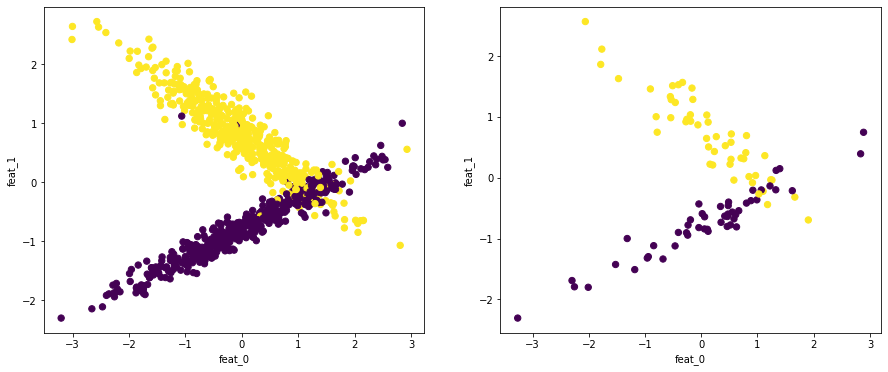

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
ax[0].scatter(X_train_scaled.values[:, 0], X_train_scaled.values[:, 1], c=Y_train.values, s=40)
ax[0].set_xlabel('feat_0')
ax[0].set_ylabel('feat_1')
ax[1].scatter(X_test_scaled.values[:, 0], X_test_scaled.values[:, 1], c=Y_test.values, s=40) #marker='s'
ax[1].set_xlabel('feat_0')
ax[1].set_ylabel('feat_1')

# 2. Model

## Approximated function: 

### $$\pmb{\hat{y}_i} = f(\pmb{x_i}, W) = \pmb{f^{h}}^T\pmb{w^{out}} \in R^K;~~\pmb{w^{out}}\in R^{d_h\times K}$$
Donde
$$\pmb{f^1} = g(\pmb{x_i}^T\pmb{w^1}) \in R^{d_1};~~\pmb{w^1}\in R^{D\times d_1}$$
$$\pmb{f^2} = g(\pmb{f^1}^T\pmb{w^2}) \in R^{d_2};~~\pmb{w^2}\in R^{d1\times d_2}$$
$$~~~~...~~~~$$
$$\pmb{f^h} = g(\pmb{f^{h-1}}^T\pmb{w^h}) \in R^{d_h};~~\pmb{w^h}\in R^{d_{h-1}\times d_h}$$

$W = \{\pmb{w^1}, \pmb{w^2}, \pmb{w^3},...,\pmb{w^h}, \pmb{w^{out}}\}$; 

- $g(\bullet)$ is an activation function.   
- input layer: $f^1$
- output layer: $f$
- hidden layers: $f^2, f^3, ..., f^h$
- depth: number of hidden layers.

https://playground.tensorflow.org/

In [9]:
input_shape = 2
output_shape = 4
dict_parameters = {}
dict_parameters['units'] = 500
dict_parameters['dropout'] = 0.2
dict_parameters['hidden'] = 2#4
dict_parameters['rate_var_units'] = 0.9
dict_parameters['rate_var_drop'] = 0.9
dict_parameters['activation'] = 'relu'

In [10]:
## Read the model
model = define_ffnn_model(input_shape, output_shape, dict_parameters)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 500)               1500      
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 450)               225450    
                                                                 
 activation_1 (Activation)   (None, 450)               0         
                                                                 
 dropout_1 (Dropout)         (None, 450)               0     

In [23]:
# show_information_layer(model, 'dense_20', X_train_scaled[0:2].values, show_weights=True) 
# show_information_layer(model, 'activation_10', X_train_scaled[0:2].values, show_weights=True) 
# show_information_layer(model, 'dense_23', X_train_scaled[0:2].values, show_weights=True) 
# print('same output as')
# model(X_train_scaled[0:2].values).numpy()

# 3. Entrenamiento
## Loss function: cross-entropy

$$L(W) = -\frac{1}{N}\sum_{i=1}^N log(S(f(\pmb{x_i}, W), y_i))$$

Where $S(f(\pmb{x_i}, W), y_i)$ is the softmax function defined as: 

$$S(f(\pmb{x_i}, W), y_i) = \frac{exp(\pmb{f^{h}}^T\pmb{w_{yi}^{out}})}{\sum_{k=1}^K exp(\pmb{f^{h}}^T\pmb{w_{yk}^{out}})}$$

## Encontrar $\hat{W}$ que minimize $L(\hat{W})$

# Optimization usando SGD

In [14]:
is_evaluation = False
batch_size = 256
num_epochs  = 500
learning_rate = 0.1

In [15]:
list_callbacks = []

train_ds = make_dataset(x_train.values,    
                        y_train.values,
                        batch_size=batch_size,
                        is_training=True)            

valid_ds = make_dataset(x_val.values,    
                        y_val.values,
                        batch_size=batch_size,
                        is_training=False)          

##Training
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')   
list_callbacks.append(early_stop) 

### model ###
model = define_ffnn_model(input_shape, output_shape, dict_parameters)

### loss function ###
#loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Optimization ###
# optimizer = tf.optimizers.Adam(dict_parameters['learning_rate'])
optimizer = tf.optimizers.SGD(learning_rate)

### metrics ###
metrics = ['accuracy']

### model compile and fit ###
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)    

Epoch 1/500
3/3 [==============================] - 1s 92ms/step - loss: 6.0284 - accuracy: 0.7681 - val_loss: 5.8254 - val_accuracy: 0.9222
Epoch 2/500
3/3 [==============================] - 0s 29ms/step - loss: 5.7756 - accuracy: 0.9139 - val_loss: 5.5760 - val_accuracy: 0.9111
Epoch 3/500
3/3 [==============================] - 0s 20ms/step - loss: 5.5437 - accuracy: 0.9042 - val_loss: 5.3535 - val_accuracy: 0.9111
Epoch 4/500
3/3 [==============================] - 0s 22ms/step - loss: 5.3294 - accuracy: 0.9125 - val_loss: 5.1628 - val_accuracy: 0.9111
Epoch 5/500
3/3 [==============================] - 0s 26ms/step - loss: 5.1501 - accuracy: 0.9056 - val_loss: 5.0065 - val_accuracy: 0.9111
Epoch 6/500
3/3 [==============================] - 0s 19ms/step - loss: 4.9912 - accuracy: 0.9069 - val_loss: 4.8798 - val_accuracy: 0.9111
Epoch 7/500
3/3 [==============================] - 0s 22ms/step - loss: 4.8686 - accuracy: 0.9056 - val_loss: 4.7759 - val_accuracy: 0.9111
Epoch 8/500
3/3 [===

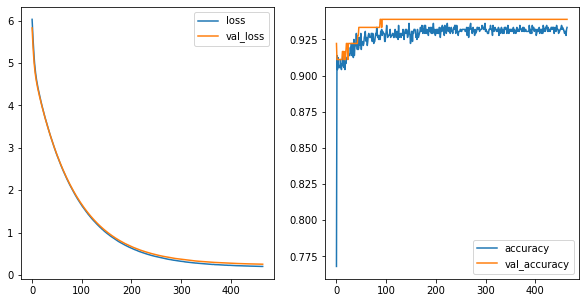

In [16]:
history = model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds, 
                    callbacks=list_callbacks)            
show_curves(history)


# 4 Evaluacion 

In [17]:
train_ds_tmp = make_dataset(X_train_scaled.values,    
                        Y_train.values,
                        batch_size=batch_size,
                        is_training=False)            

test_ds = make_dataset(X_test_scaled.values,    
                       Y_test.values,
                        batch_size=batch_size,
                        is_training=False)       

In [18]:
y_train_tmp, y_train_pred_prob = get_predictions(train_ds)
y_test_tmp, y_test_pred_prob = get_predictions(test_ds)

# ## check probabilities
# np.mean(np.sum(y_train_pred_prob, axis=1))

## compute metrics train
dict_metrics_train = compute_metrics_classification(y_train_tmp, predict_classes(y_train_pred_prob)[0], average='binary')
# dict_metrics_train = compute_metrics_classification(y_train_tmp, predict_classes(y_train_pred_prob)[0], average='macro')
dict_curves_train = compute_curves(y_train_tmp, y_train_pred_prob, pos_label=1)

## compute metrics test
dict_metrics_test = compute_metrics_classification(y_test_tmp, predict_classes(y_test_pred_prob)[0], average='binary')
# dict_metrics_test = compute_metrics_classification(y_test_tmp, predict_classes(y_test_pred_prob)[0], average='macro')
dict_curves_test = compute_curves(y_test_tmp, y_test_pred_prob, pos_label=1)

df_results_metrics = pd.DataFrame([dict_metrics_train, dict_metrics_test])
df_results_metrics.index = ['metric_train', 'metric_test']

df_results_curves = pd.DataFrame([dict_curves_train, dict_curves_test])
df_results_curves.index = ['curves_train', 'curves_test']
df_results_curves

print(df_results_metrics)
print()
print(df_results_curves)

precision-recall curve for the class  1
precision-recall curve for the class  1
                   acc  presicion    recall  balanced
metric_train  0.931944   0.978659  0.884298  0.932345
metric_test   0.920000   0.956522  0.880000  0.920000

              pr_curve  roc_curve
curves_train  0.989151   0.987731
curves_test   0.987268   0.986400


precision-recall curve for the class  0


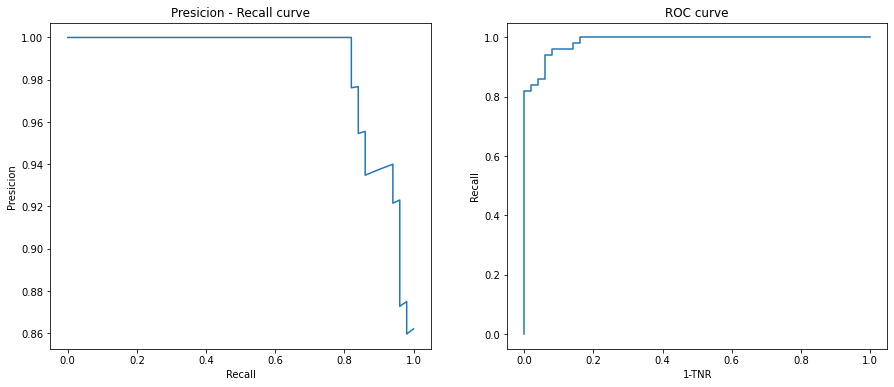

In [19]:
dict_curves_test = compute_curves(y_test_tmp, y_test_pred_prob, pos_label=0, plot=True)

precision-recall curve for the class  1


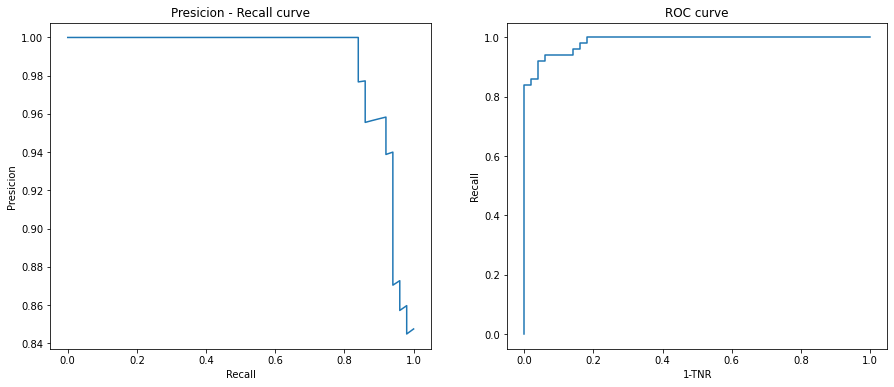

In [20]:
dict_curves_test = compute_curves(y_test_tmp, y_test_pred_prob, pos_label=1, plot=True)

4477/4477 [==============================] - 13s 3ms/step


<Figure size 432x288 with 0 Axes>

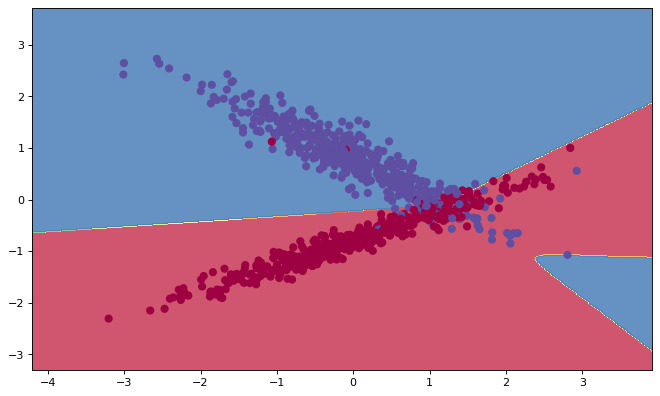

<Figure size 432x288 with 0 Axes>

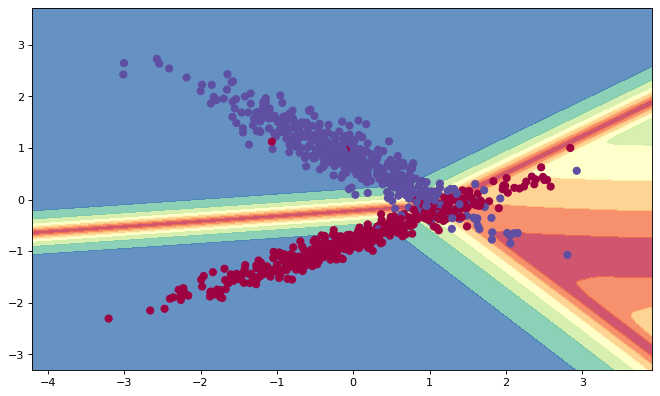

In [21]:
values = ploting_probilities_surfaces(X_train_scaled.values, Y_train.values, model, figsize=(10, 6))

4938/4938 [==============================] - 18s 4ms/step


<Figure size 432x288 with 0 Axes>

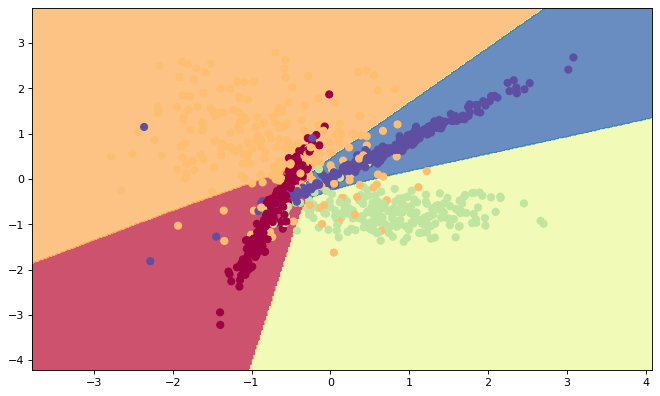

<Figure size 432x288 with 0 Axes>

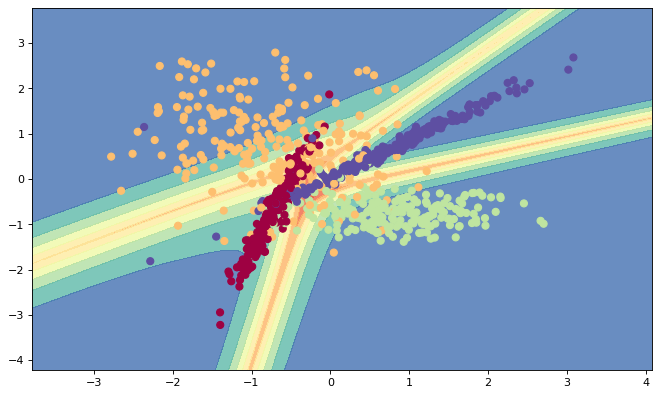

In [32]:
values = ploting_probilities_surfaces(X_train_scaled.values, Y_train.values, model, figsize=(10, 6))